# Machine Learning Supervisado: Guía Práctica Paso a Paso

En este notebook aprenderás a:

### Preparar un dataset para entrenamiento
- División correcta en entrenamiento y test (train/test split)
- Validación cruzada (StratifiedKFold)
- Estandarización y otros tipos de escalado (StandardScaler, MinMaxScaler, RobustScaler)
- Detección básica de outliers (opcional)

### Entrenar clasificadores clásicos
- k-Nearest Neighbors (kNN)
- Regresión Logística
- SVM (Support Vector Machines)
- Random Forest
- Gradient Boosting
- Naive Bayes

### Evaluar modelos supervisados
- Accuracy
- Precision, Recall, F1
- Matriz de confusión
- ROC-AUC
- Curva ROC
- Curva Precision-Recall

### Optimizar hiperparámetros
- GridSearchCV
- RandomizedSearchCV
- Halving Grid Search (Successive Halving)

### Interpretación y análisis del modelo
- Importancia de variables (Random Forest y Gradient Boosting)
- Coeficientes (Regresión Logística)
- Visualización de fronteras de decisión (solo para 2D)

### Usar el modelo entrenado para predicción en nuevos datos

Este notebook está diseñado para **educación** y **aprendizaje estructurado**, mostrando las buenas prácticas recomendadas.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    cross_val_score,
    GridSearchCV, 
    RandomizedSearchCV
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

np.random.seed(42)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)


## 1. Dataset

Usaremos el dataset **Breast Cancer Wisconsin**, un clásico para clasificación binaria:

- 570 muestras
- 30 variables numéricas
- Etiquetas: 0 = maligno, 1 = benigno

Ideal para practicar ML supervisado.


- Exploración inicial

In [4]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Shape:", X.shape)
X.head()


Shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


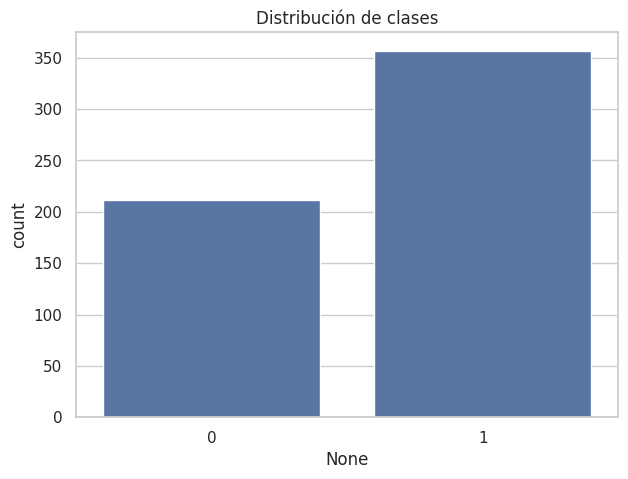

1    0.627417
0    0.372583
Name: proportion, dtype: float64

In [5]:
sns.countplot(x=y)
plt.title("Distribución de clases")
plt.show()

y.value_counts(normalize=True)


## 2. División Train/Test

Es fundamental evitar *data leakage*.

Usamos:
- **80%** para entrenamiento
- **20%** para test
- `stratify=y`: conserva proporciones de clases


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((455, 30), (114, 30))

## 3. Estandarización (Scaling)

Muchos modelos son sensibles a la escala:

- kNN  
- SVM  
- Regresión logística  

Compararemos tres escaladores:

- StandardScaler → media = 0, var = 1 (el más usado)
- MinMaxScaler → escala entre 0 y 1
- RobustScaler → usa mediana, robusto a outliers


In [7]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
}

scaled_versions = {}

for name, scaler in scalers.items():
    scaler.fit(X_train)
    scaled_versions[name] = (
        scaler.transform(X_train),
        scaler.transform(X_test)
    )


## 4. Modelos clásicos a evaluar

- **kNN**
- **Regresión logística**
- **SVM (kernels lineal y RBF)**
- **Random Forest**
- **Gradient Boosting**
- **Gaussian Naive Bayes**

Usaremos validación cruzada para evaluar correctamente cada modelo.


In [8]:
models = {
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=3000, random_state=42),
    "SVM Linear": SVC(kernel="linear", probability=True, random_state=42),
    "SVM RBF": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}


- Evaluación con validación cruzada

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for model_name, model in models.items():
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="accuracy")
    results[model_name] = scores
    print(f"{model_name}: {scores.mean():.4f} ± {scores.std():.4f}")


kNN: 0.9604 ± 0.0112
Logistic Regression: 0.9780 ± 0.0098
SVM Linear: 0.9648 ± 0.0162
SVM RBF: 0.9670 ± 0.0155
Random Forest: 0.9626 ± 0.0179
Gradient Boosting: 0.9516 ± 0.0149
Naive Bayes: 0.9341 ± 0.0287


## 5. Comparación visual de modelos


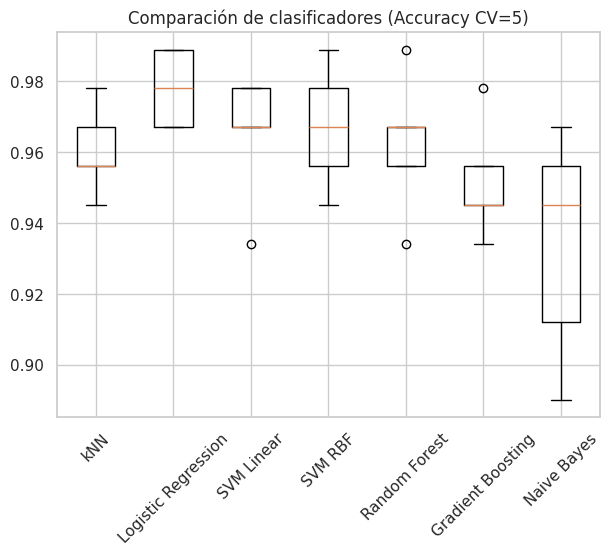

In [10]:
plt.boxplot(results.values(), labels=results.keys())
plt.title("Comparación de clasificadores (Accuracy CV=5)")
plt.xticks(rotation=45)
plt.show()


## 6. Selección y entrenamiento final del mejor modelo

Por simplicidad, trabajaremos con **Random Forest**, que suele tener buen desempeño y es interpretable.


In [11]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


## 7. Métricas de evaluación


              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



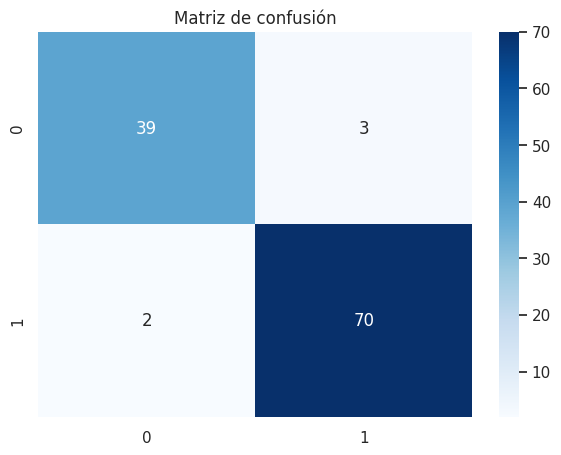

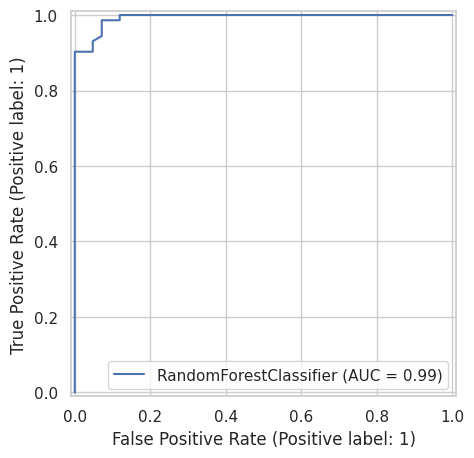

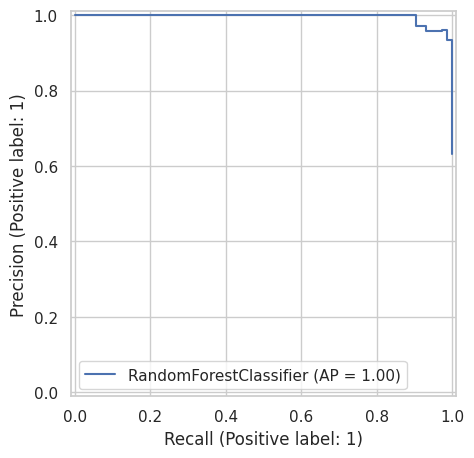

In [12]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.show()

# Curva Precision-Recall
PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
plt.show()


## 8. Interpretación del modelo

Random Forest permite inspeccionar **importancia de características**.


In [13]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


worst perimeter         0.133100
worst area              0.128052
worst concave points    0.108107
mean concave points     0.094414
worst radius            0.090639
mean radius             0.058662
mean perimeter          0.055242
mean area               0.049938
mean concavity          0.046207
worst concavity         0.035357
dtype: float64

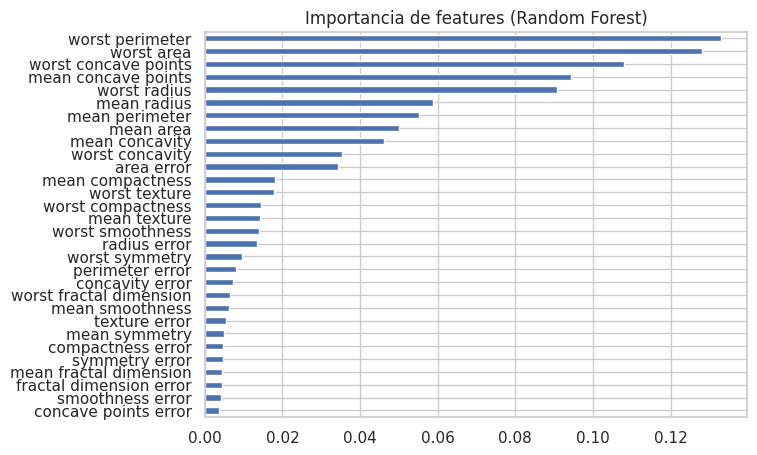

In [14]:
importances.sort_values().plot(kind="barh")
plt.title("Importancia de features (Random Forest)")
plt.show()


## 9. Optimización de hiperparámetros

Alternativas:
- GridSearchCV
- RandomizedSearchCV
- HalvingGridSearchCV (Successive Halving)


In [15]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 4, 8]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor accuracy:", grid.best_score_)


Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Mejor accuracy: 0.964835164835165


## 10. Cómo usar el modelo para predicción

Siempre debes:
1. Cargar tu modelo entrenado  
2. Cargar tu scaler  
3. Escalar los nuevos datos  
4. Predecir con `model.predict()`


In [16]:
nuevo = X_test.iloc[[0]]

print("Nuevo dato:\n", nuevo)

nuevo_scaled = scaler.transform(nuevo)
pred = model.predict(nuevo_scaled)
prob = model.predict_proba(nuevo_scaled)

print("Predicción:", pred)
print("Probabilidades:", prob)


Nuevo dato:
      mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
256        19.55         28.77           133.6     1207.0           0.0926   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
256            0.2063          0.1784               0.1144         0.1893   

     mean fractal dimension  ...  worst radius  worst texture  \
256                 0.06232  ...         25.05          36.27   

     worst perimeter  worst area  worst smoothness  worst compactness  \
256            178.6      1926.0            0.1281             0.5329   

     worst concavity  worst concave points  worst symmetry  \
256           0.4251                0.1941          0.2818   

     worst fractal dimension  
256                   0.1005  

[1 rows x 30 columns]
Predicción: [0]
Probabilidades: [[1. 0.]]


# Conclusiones

En este notebook aprendimos:

- Cómo dividir correctamente un dataset.
- Cuándo y por qué aplicar diferentes scalers.
- Cómo comparar multiple clasificadores.
- Cómo usar validación cruzada para evaluar modelos.
- Qué métricas son importantes en clasificación (accuracy, recall, F1, AUC).
- Cómo optimizar hiperparámetros con GridSearch y RandomizedSearch.
- Cómo interpretar modelos (importancia de features).
- Cómo predecir nuevos datos correctamente.

Este flujo corresponde a un pipeline profesional completo de ML supervisado.
